## SNR
The SNR-ratio can be defined by the following function:
\begin{equation}
    SNR = |V_{12}|^2 \cdot \varepsilon \cdot A \cdot \Phi \cdot \sqrt{\frac{T}{\Delta t}}
\end{equation}
where 
\begin{align}
    |V_{12}| &: \text{complex visiblity [unitless]} \\
    \alpha &: \text{efficiency  [unitless]} \\
    A &: \text{area in [m$^2$]} \\
    \Phi &: \text{spectral photon flux in [m$^{−2}$ s$^{−1}$ Hz$^{−1}$]} \\
    T &: \text{observation or integration time in [s] or [hrs]} \\
    \Delta t &: \text{time resolution in [s]}
\end{align}

In [1]:
import numpy as np
from brightstar_functions import Phi
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
# for the simple SNR
V_12 = 1
alpha = 0.125 # = 0.5*0.25
diameter = 1 # m
delta_t = 1e-12 # s, time resolution
wavelength = 540e-9 # m, bandwidth of V-mag
mag = 0

effective_diameter = 0.95

##################################################################################################################################

# for the case including optical and quantum efficiency, number of channels and background flux explicitly
efficiency_o = 0.5
efficiency_d = 0.4
B = 0
N_channel = 1

##################################################################################################################################

# for the case with two telescopes:
epsilon_O_1 = efficiency_o
epsilon_O_2 = efficiency_o
epsilon_D_1 = efficiency_d
epsilon_D_2 = efficiency_d

B_1 = B
B_2 = B

delta_t_1 = delta_t 
delta_t_2 = delta_t

diameter_1 = diameter # m
diameter_2 = diameter # m
effective_diameter_1 = effective_diameter 
effective_diameter_2 = effective_diameter

##################################################################################################################################

# including the width of filter for the count rate and random coincidences
delta_lambda = 1e-9 # nm

##################################################################################################################################

# calculating effective areas:
def area_sub(diameter, effective_diameter):
    return np.pi*(diameter*effective_diameter/2)**2 #m^2


In [3]:
def SNR_simple(T, magnitude, diameter):
    efficiency_o = 0.5 # optical efficiency
    efficiency_d = 0.4 # detector efficiency
    efficiency_f = 0.5 # filter efficiency
    efficiency_p = 1 # 1 means no polarizer, 0.5 with
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    return V_12**2*efficiency_overall*area_sub(diameter, effective_diameter)*Phi(magnitude, wavelength)*np.sqrt(T/delta_t)

print('SNR: ', SNR_simple(3600, 0, 0.5))

SNR:  52.4705217613015


More explicitly we can express SNR as:
\begin{equation}
    SNR = |V_{12}|^2 \cdot \varepsilon_o \cdot \varepsilon_d \cdot \frac{A}{1+B/\Phi} \cdot \Phi \cdot \sqrt{\frac{T}{\Delta t}} \cdot \sqrt{N_\text{chan}}
\end{equation}
where we additionally have
\begin{align}
    \epsilon_o &: \text{optical efficiency [unitless]} \\
    \epsilon_d &: \text{detector or quantum efficiency [unitless]} \\
    B &: \text{background flux in [m$^{−2}$ s$^{−1}$ Hz$^{−1}$]} \\
    N_{chan} &: \text{number of channels [unitless]} \\
\end{align}

In [4]:
def SNR_(T, magnitude, diameter):
    efficiency = efficiency_o*efficiency_d
    Phi_ = Phi(magnitude, wavelength)
    area_ = area_sub(diameter, effective_diameter)/((1+B/Phi_))
    return V_12**2*area_*Phi_*np.sqrt(T/delta_t)*efficiency*np.sqrt(N_channel)

print('SNR: ', SNR_(3600, mag, diameter))

SNR:  419.764174090412


For two telescopes of different diameters, efficiencies, background flux and time resolution we have:
\begin{align}
    SNR &= |V_{12}|^2 \cdot \sqrt{\varepsilon_{o,1}\varepsilon_{o,2}} \cdot \sqrt{\varepsilon_{d,1}\varepsilon_{d,2}} \cdot \sqrt{\frac{A_1A_2}{(1+B_1/\Phi)(1+B_2/\Phi)}}\cdot \Phi \cdot
    \sqrt{\frac{T}{\sqrt{\Delta t_1\Delta t_2}}} \cdot \sqrt{N_\text{chan}}
\end{align}

In [5]:
def SNR_two(T, magnitude, diameter1, diameter2, effective_diameter1, effective_diameter2):
    efficiency = np.sqrt(epsilon_O_1*epsilon_O_1)*np.sqrt(epsilon_D_1*epsilon_D_1)
    Phi_ = Phi(magnitude, wavelength)
    area_ = np.sqrt(area_sub(diameter1, effective_diameter1)*area_sub(diameter2, effective_diameter2)/((1+B_1/Phi_)*(1+B_2/Phi_)))
    return V_12**2*area_*Phi_*np.sqrt(T/np.sqrt(delta_t_1*delta_t_2))*efficiency*np.sqrt(N_channel)

print('SNR: ', SNR_two(3600, mag, diameter_1, diameter_2, effective_diameter_1, effective_diameter_2))

SNR:  419.764174090412


We can also check the source count per second:
\begin{equation}
    N_\text{count} = \varepsilon \cdot \Phi \cdot \Delta \nu \cdot A
\end{equation}
with
\begin{equation}
    \Delta \nu = \frac{c \cdot \Delta \lambda}{\lambda^2}
\end{equation}

In [6]:
def count_rate(mag, diameter):
    Phi_ = Phi(mag, wavelength)
    #print('Phi: ',Phi_)
    delta_nu = c*delta_lambda/(wavelength**2)
    efficiency_o = 0.5 # optical efficiency
    efficiency_d = 0.4 # detector efficiency
    efficiency_f = 0.5 # filter efficiency
    efficiency_p = 1 # 1 means no polarizer, 0.5 with
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    return efficiency_overall*delta_nu*Phi_*area_sub(diameter, effective_diameter)

print('count rate: ', count_rate(0, 0.5))

count rate:  899077.8858803764


## Random Coincidence Count
The random coincidence count (in other words, the baseline) per $\Delta t$ is:
\begin{equation}
    N_\text{random, per \Delta t} &= 2 \cdot \left(\frac{1}{2} \cdot \varepsilon \cdot \Phi \cdot \Delta \nu \cdot A\right)^2 \cdot \Delta t^2 = 2 \cdot \left(\frac{1}{2} \cdot N_\text{count}\right)^2 \cdot \Delta t^2
\end{equation}
The factor 0.5 comes from splitting the beam into two (one for SPAD, one for CCD). \
So random coincidence count per second is:
\begin{equation}
    N_\text{random, per s} &= 2 \cdot \left(\frac{1}{2} \cdot\varepsilon \cdot \Phi \cdot \Delta \nu \cdot A\right)^2 \cdot \Delta t = 2 \cdot \left(\frac{1}{2} \cdot N_\text{count}\right)^2 \cdot \Delta t
\end{equation}

In [7]:
def coincidences(T, magnitude, diameter):
    return 2*((count_rate(magnitude, diameter)/2)**2)*delta_t*T


print('random coincidences', coincidences(1, 0, 0.5))

((((count_rate(0, 0.5))/2)**2)*1e-12)*3600

random coincidences 0.4041705224395636


727.5069403912145

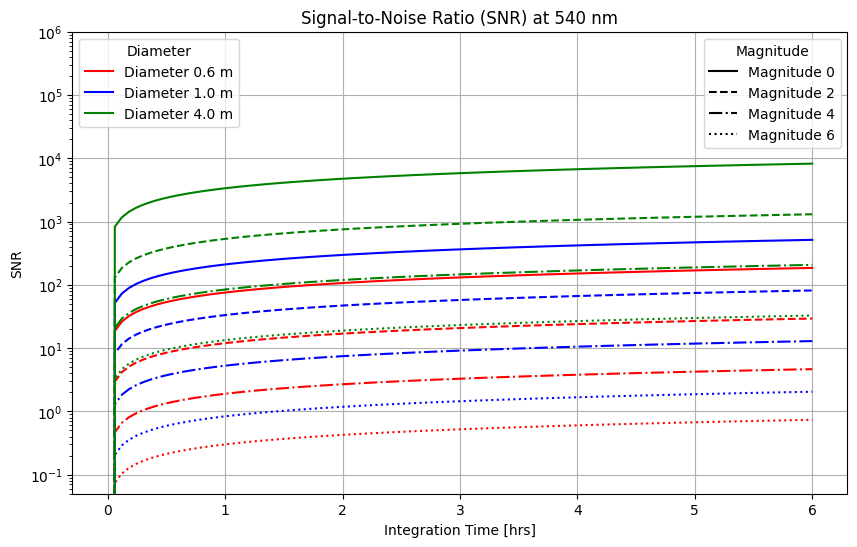

In [8]:
T_0 = np.linspace(0, 6, 100)
diameters = [0.6, 1.0, 4.0]
magnitudes = [0, 2, 4, 6]

# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 6))

colors = ['r', 'b', 'g']  # Different colors for different diameters
linestyles = ['-', '--', '-.', ':']  # Different linestyles for different magnitudes


for i, diameter in enumerate(diameters):
    for j, magnitude in enumerate(magnitudes):
        snr_values = [SNR_simple(t * 3600, magnitude, diameter) for t in T_0]
        plt.plot(T_0, snr_values, color=colors[i], linestyle=linestyles[j], 
                 label=f'Diameter {diameter} m, Mag {magnitude}')
        
plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) at 540 nm')
diameter_legends = [mlines.Line2D([], [], color=colors[i], linestyle='-', label=f'Diameter {d} m')
                    for i, d in enumerate(diameters)]
magnitude_legends = [mlines.Line2D([], [], color='black', linestyle=linestyles[i], label=f'Magnitude {m}')
                     for i, m in enumerate(magnitudes)]

legend1 = plt.legend(handles=diameter_legends, loc='upper left', title="Diameter")
plt.gca().add_artist(legend1)  # Add the first legend manually
plt.legend(handles=magnitude_legends, loc='upper right', title="Magnitude")
plt.yscale("log")
plt.ylim(5e-2, 1e6)

plt.grid(True)
plt.show()

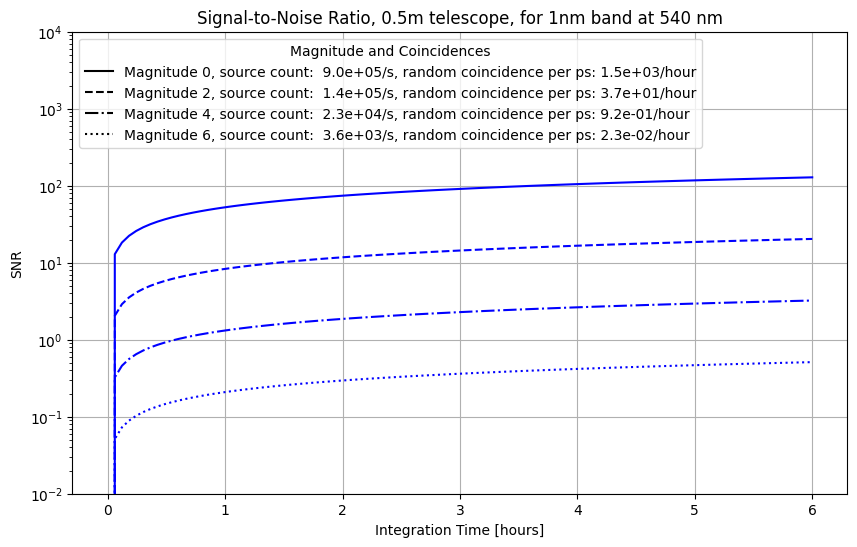

In [9]:
T_0 = np.linspace(0, 6, 100)
magnitudes = [0, 2, 4, 6]

plt.figure(figsize=(10, 6))

colors = ['r', 'b', 'g']  # Different colors for different diameters
linestyles = ['-', '--', '-.', ':']  # Different linestyles for different magnitudes

legend_entries = []
diameter = 0.5
for j, magnitude in enumerate(magnitudes):
    snr_values = [SNR_simple(t * 3600, magnitude, diameter) for t in T_0]
    plt.plot(T_0, snr_values, color='b', linestyle=linestyles[j], 
                 label=f'Diameter {diameter} m, Mag {magnitude}')
    coinc = coincidences(3600, magnitude, diameter)
    sourcec = count_rate(magnitude, diameter)
    legend_entries.append(mlines.Line2D([], [], color='black', linestyle=linestyles[j],
                                        label=f'Magnitude {magnitude}, source count:  {sourcec:.1e}/s, random coincidence per ps: {coinc:.1e}/hour'))
    
plt.xlabel('Integration Time [hours]')
plt.ylim(1e-2, 1e4)
plt.ylabel('SNR')
plt.title(f'Signal-to-Noise Ratio, {diameter}m telescope, for 1nm band at 540 nm')



plt.legend(handles=legend_entries, loc='upper left', title="Magnitude and Coincidences")
plt.yscale("log")

plt.grid(True)
plt.show()

In [10]:
# determine after how many seconds until the number of random coincidences has reached a million
def rand_coincidences1M(diameter, magnitude):
    return 1e6/(2*((count_rate(magnitude, diameter)/2)**2)*delta_t)

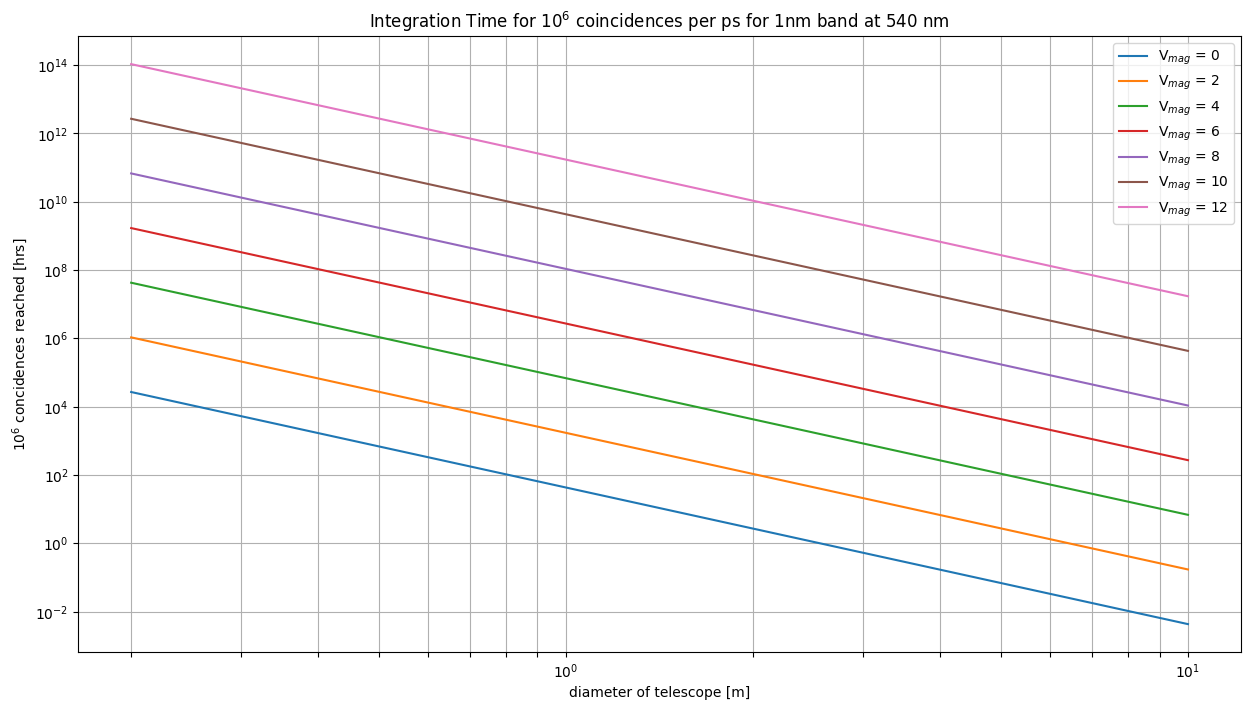

In [11]:
plt.figure(figsize=(15, 8))

magnitudes1 = [0, 2, 4, 6, 8, 10, 12]
diameters = np.linspace(0.2, 10, 100)
for index, mag in enumerate(magnitudes1):
    plt.plot(diameters, rand_coincidences1M(diameters, mag)/3600, label=f'V$_{{mag}}$ = {mag}')
plt.xlabel('diameter of telescope [m]')
plt.ylabel('10$^6$ concidences reached [hrs]')
plt.title('Integration Time for 10$^6$ coincidences per ps for 1nm band at 540 nm')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)

from matplotlib.ticker import LogLocator

# Custom tick setting for the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=15))  # More dense ticks


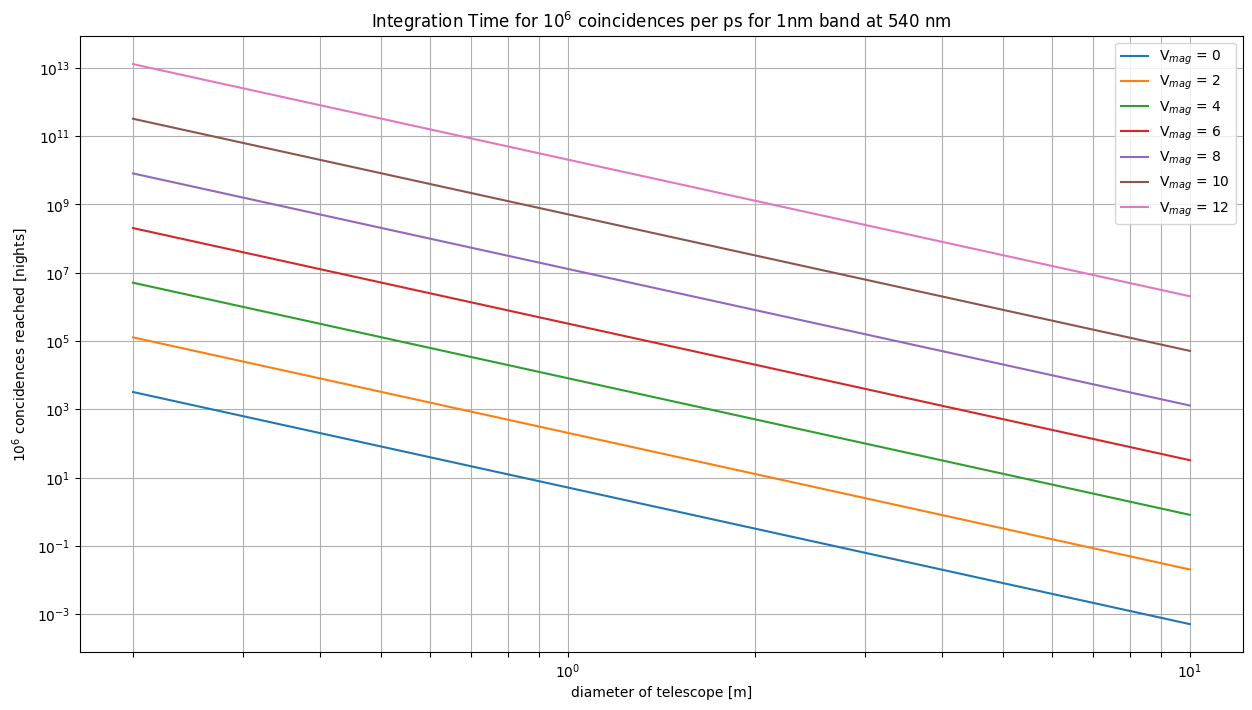

In [12]:
plt.figure(figsize=(15, 8))

magnitudes1 = [0, 2, 4, 6, 8, 10, 12]
diameters = np.linspace(0.2, 10, 100)
for index, mag in enumerate(magnitudes1):
    plt.plot(diameters, rand_coincidences1M(diameters, mag)/30000, label=f'V$_{{mag}}$ = {mag}')
plt.xlabel('diameter of telescope [m]')
plt.ylabel('10$^6$ concidences reached [nights]')
plt.title('Integration Time for 10$^6$ coincidences per ps for 1nm band at 540 nm')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)

from matplotlib.ticker import LogLocator

# Custom tick setting for the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=15))  # More dense ticks
